# **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# **preprocessing Data**

In [18]:
df = pd.read_csv("heart.csv")
'print(df.duplicated().sum())'
df=df.drop_duplicates()
'print(df.duplicated().sum())'
df['chol']=pd.to_numeric(df['chol'],errors='coerce')
df.fillna(df.median(),inplace=True)

def identify_outliers(df,column):
 q1=df[column].quantile(0.25)
 q3=df[column].quantile(0.75)
 iqr=q3-q1
 lower_bound=q1-1.5*iqr
 upper_bound=q3+1.5*iqr
 outliers=df[(df[column]<lower_bound)|(df[column]>upper_bound)]
 df[column]=df[column].clip(lower=lower_bound,upper=upper_bound)
identify_outliers(df,'trestbps')
identify_outliers(df,'thalach')
identify_outliers(df,'chol')
identify_outliers(df,'oldpeak')

categorical_cols = ['cp', 'slope', 'thal', 'sex', 'fbs', 'restecg', 'exang']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# **Calculate correlation matrix**

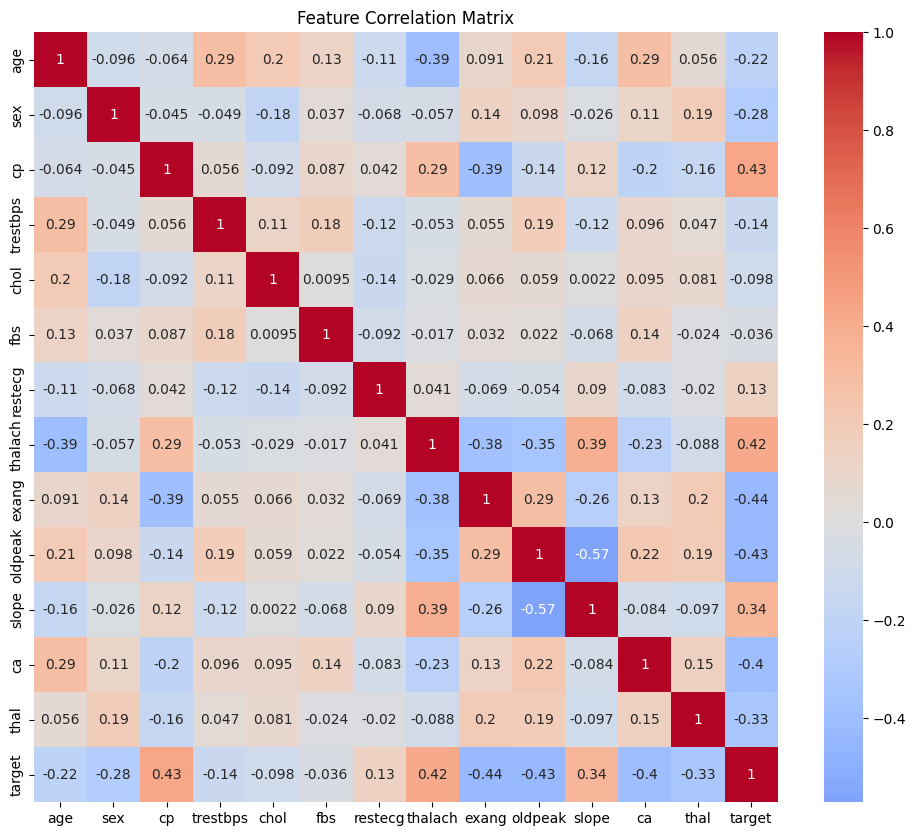

Correlation with target:
 target      1.000000
cp          0.432080
thalach     0.416243
slope       0.343940
restecg     0.134874
fbs        -0.035686
chol       -0.098352
trestbps   -0.138839
age        -0.223243
sex        -0.277867
thal       -0.332416
ca         -0.397440
oldpeak    -0.430389
exang      -0.435601
Name: target, dtype: float64


In [19]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()
target_corr = corr_matrix['target'].sort_values(ascending=False)
print("Correlation with target:\n", target_corr)
df = df.drop(['fbs', 'restecg','trestbps','chol'], axis=1)

# **Training & Testing data**

In [20]:
x=df.drop(['target'],axis=1)
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# **Standardization**

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# **logistic Regression from scratch**

In [22]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def initialize_weights(n_features):
    weights = np.zeros(n_features)
    bias = 0
    return weights, bias

def compute_predictions(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    return sigmoid(linear_model)

def compute_cost(y, y_pred):
    m = len(y)
    return - (1/m) * np.sum(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))

def gradient_descent(X, y, weights, bias, learning_rate, iterations):
    m = len(y)
    for i in range(iterations):
        y_pred = compute_predictions(X, weights, bias)
        cost = compute_cost(y, y_pred)

        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)

        weights -= learning_rate * dw
        bias -= learning_rate * db

        if i % 100 == 0:
            print(f"Iteration {i}, Cost: {cost:.4f}")
    return weights, bias

weights, bias = initialize_weights(X_train.shape[1])
weights, bias = gradient_descent(X_train, y_train, weights, bias, learning_rate=0.01, iterations=1000)
def predict(X, weights, bias):
    y_pred = compute_predictions(X, weights, bias)
    return [1 if i >= 0.5 else 0 for i in y_pred]

y_pred_custom = predict(X_test, weights, bias)
acc = accuracy_score(y_test, y_pred_custom)
print("Logistic Regression:", acc)

Iteration 0, Cost: 0.6931
Iteration 100, Cost: 0.5211
Iteration 200, Cost: 0.4579
Iteration 300, Cost: 0.4280
Iteration 400, Cost: 0.4114
Iteration 500, Cost: 0.4011
Iteration 600, Cost: 0.3943
Iteration 700, Cost: 0.3896
Iteration 800, Cost: 0.3862
Iteration 900, Cost: 0.3837
Logistic Regression: 0.8688524590163934


# **KNN model**

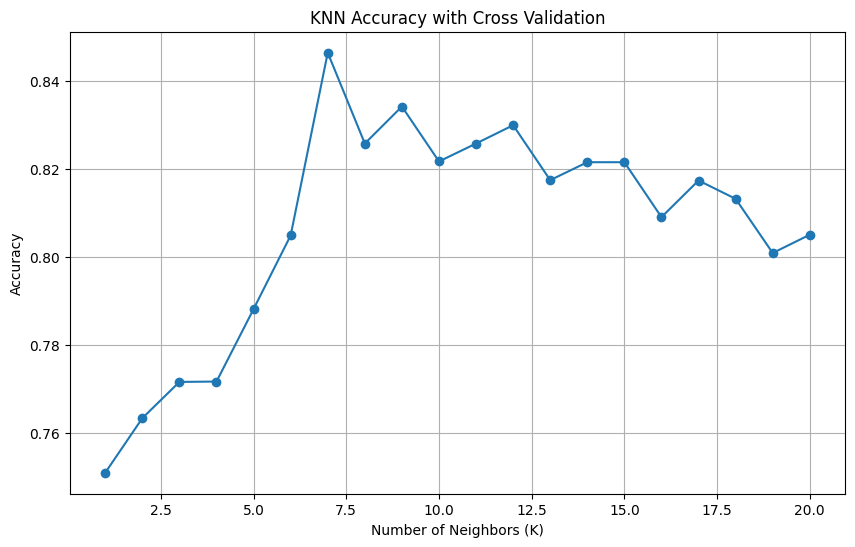

the best k: 7
Accuracy Score: 0.819672131147541


In [23]:
k_range = range(1, 21)
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o')
plt.title("KNN Accuracy with Cross Validation")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
best_k = k_range[np.argmax(cv_scores)]
print(f"the best k: {best_k}")
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# **SVM(Support Vector Machines)**

Accuracy Score: 0.9016393442622951


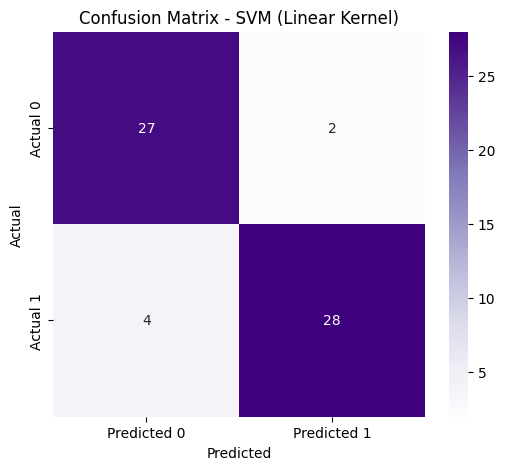

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



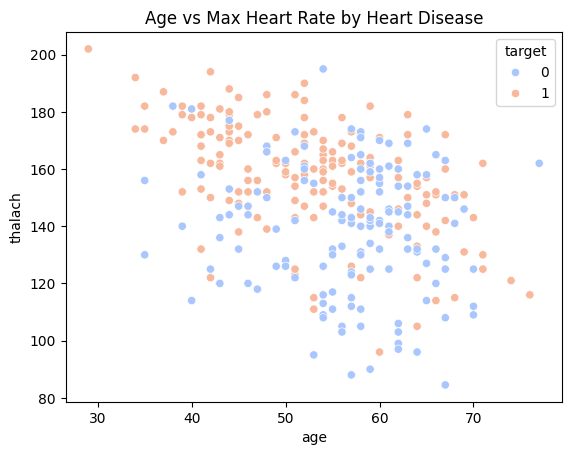

In [24]:
model = SVC(kernel='rbf', class_weight='balanced', C=1.0)
model.fit(X_train,y_train)
model.score(X_test,y_test)
y_pred=model.predict(X_test)
acc=accuracy_score(y_test,y_pred)
print("Accuracy Score:",acc)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title("Confusion Matrix - SVM (Linear Kernel)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_test,y_pred))
sns.scatterplot(data=df, x='age', y='thalach', hue='target', palette='coolwarm')
plt.title("Age vs Max Heart Rate by Heart Disease")
plt.show()

# **RelationShips With different features**


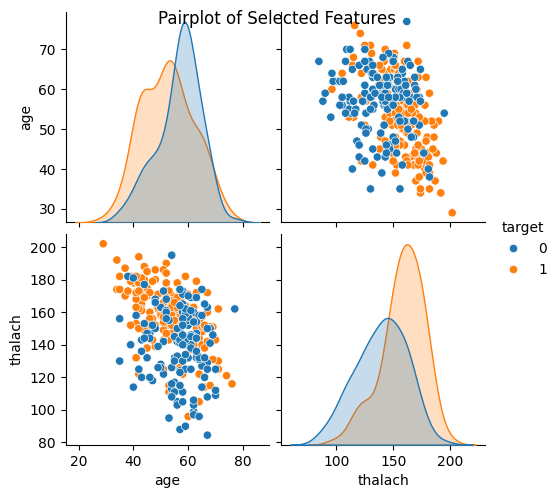

In [25]:
sns.pairplot(df[['age', 'thalach', 'target']], hue='target')
plt.suptitle("Pairplot of Selected Features")
plt.show()

# **ID3( iterative Dichotomiser 3 )**



Accuracy Score:  0.7868852459016393

Classification_report :
                precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.85      0.72      0.78        32

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.80      0.79      0.79        61



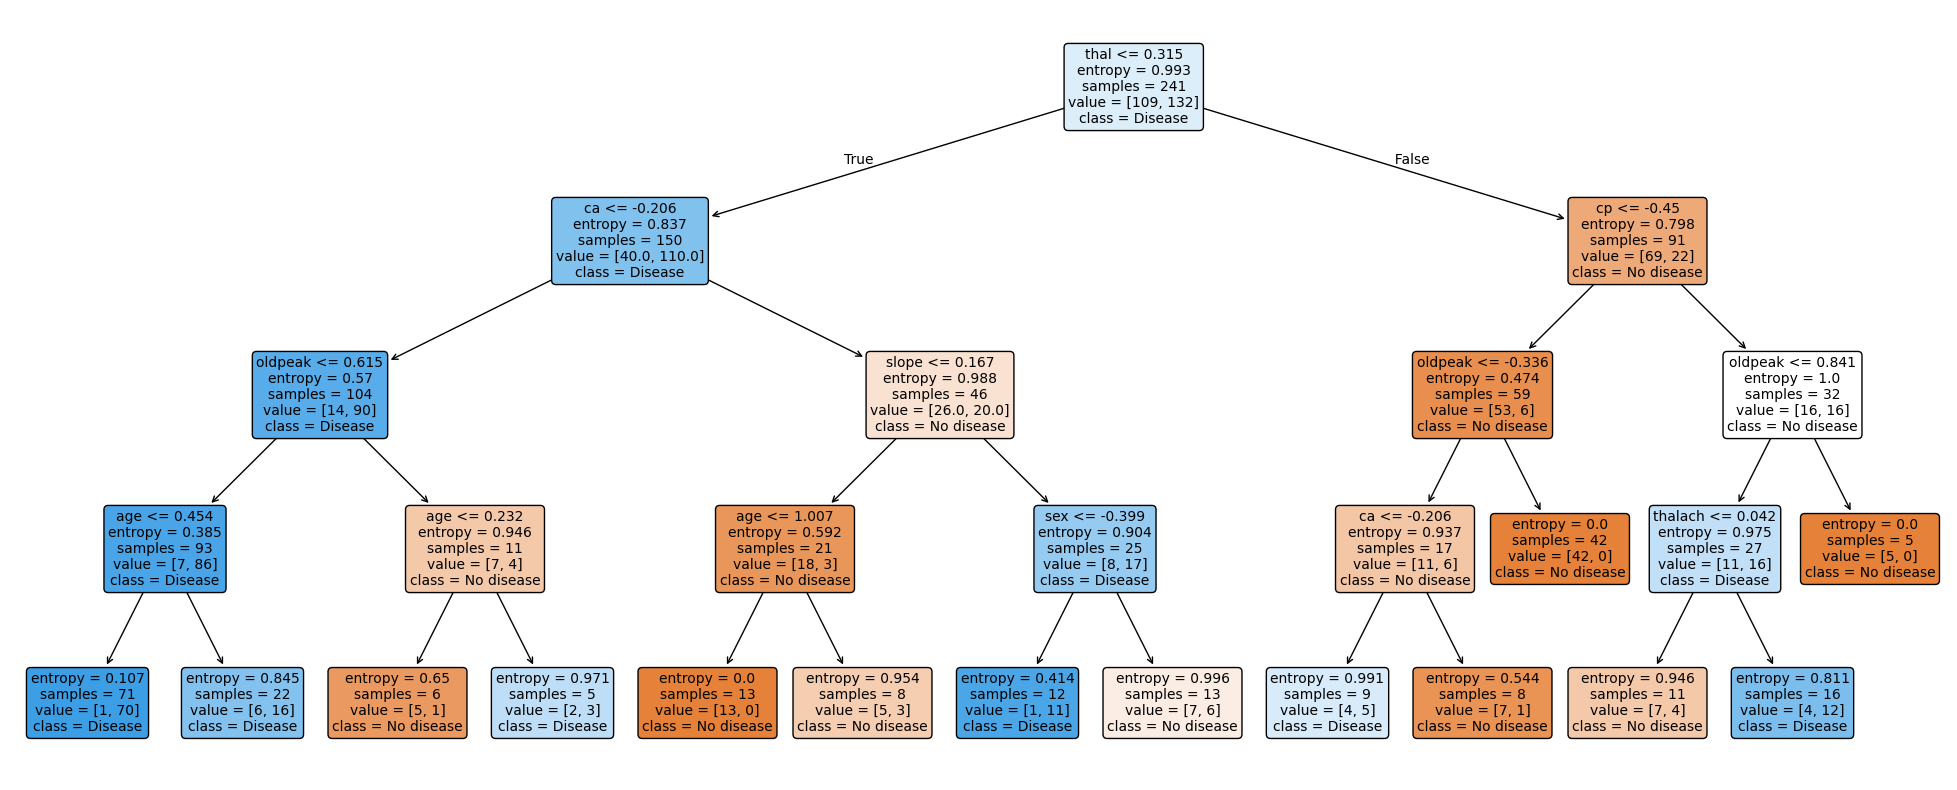

In [26]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_leaf=5,random_state=42)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test,y_pred))
print("\nClassification_report :\n ",classification_report(y_test,y_pred))

plt.figure(figsize=(25,10))
tree.plot_tree(clf,feature_names=x.columns,class_names=['No disease','Disease'],rounded=True,proportion=False,filled=True,fontsize=10)
plt.show()

# **Selection**

Random Forest Accuracy: 0.8688524590163934


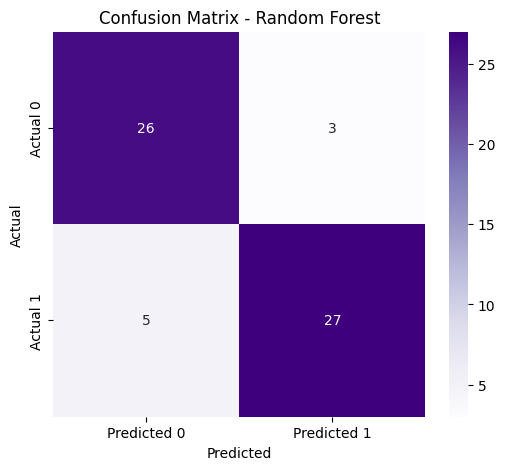

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [27]:
RandomF = RandomForestClassifier(n_estimators=100, random_state=42)
RandomF.fit(X_train, y_train)
y_pred_RandomF = RandomF.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_RandomF))
cm = confusion_matrix(y_test, y_pred_RandomF)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_test, y_pred_RandomF))

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Random Forest After Tuning
Accuracy: 0.8852459016393442


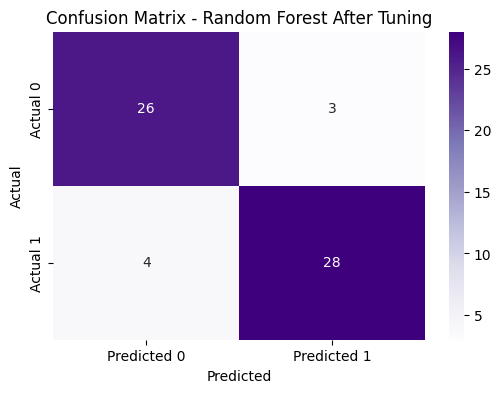

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



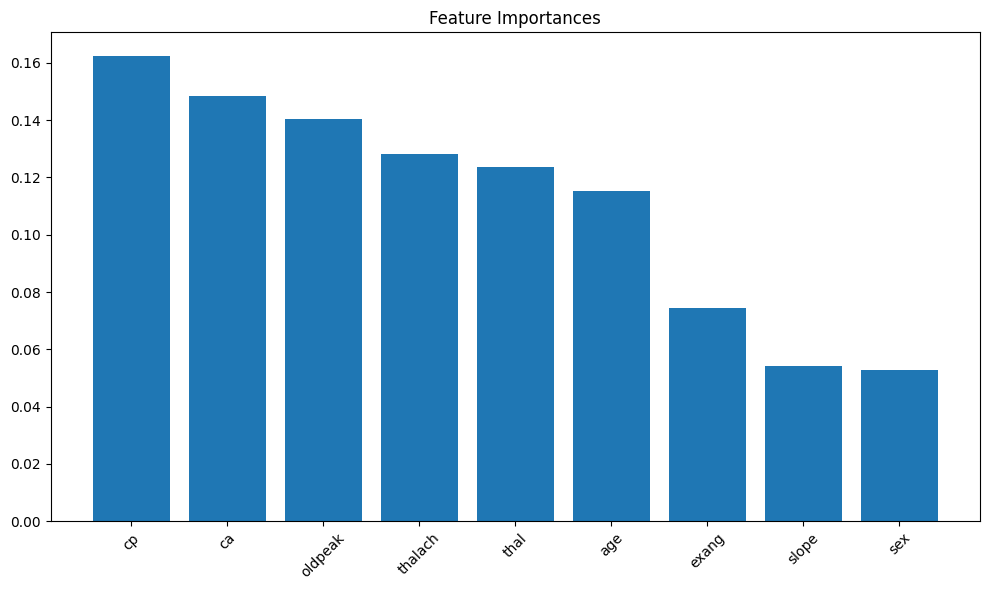

In [ ]:
def evaluate_model(model, model_name):
    y_pred = model.predict(X_test)
    print(f"\n{model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    print(classification_report(y_test, y_pred))

#improve RF
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

evaluate_model(best_rf, "Random Forest After Tuning")
model.fit
importances = best_rf.feature_importances_
features = df.drop("target", axis=1).columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), features[indices], rotation=45)
plt.tight_layout()
plt.show()

#**Model Hyperparameter Tuning**

In [29]:
#Logistic Regression Tuning
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga']
}
log_reg_grid_search = GridSearchCV(LogisticRegression(), log_reg_param_grid, cv=5, scoring='accuracy')
log_reg_grid_search.fit(X_train, y_train)
best_log_reg_model = log_reg_grid_search.best_estimator_
#KNN Tuning
knn_param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)
best_knn_model = knn_grid_search.best_estimator_
#SVM Tuning
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}
svm_grid_search = GridSearchCV(SVC(probability=True,kernel='rbf', class_weight='balanced', C=1.0), svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)
best_svm_model = svm_grid_search.best_estimator_
#Decision Tree Tuning
dt_param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(), dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)
best_dt_model = dt_grid_search.best_estimator_


In [30]:
# model_accuracies = []
# for model_name, model in models.items():
#     y_pred = model.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     model_accuracies.append({'Model': model_name, 'Accuracy': acc})

# accuracy_df = pd.DataFrame(model_accuracies)
# print("\n========================= Tuned Model Accuracy =========================")
# print(accuracy_df.to_string(index=False))
# print("========================================================================")



#**Confusion Matrices After Tuning**

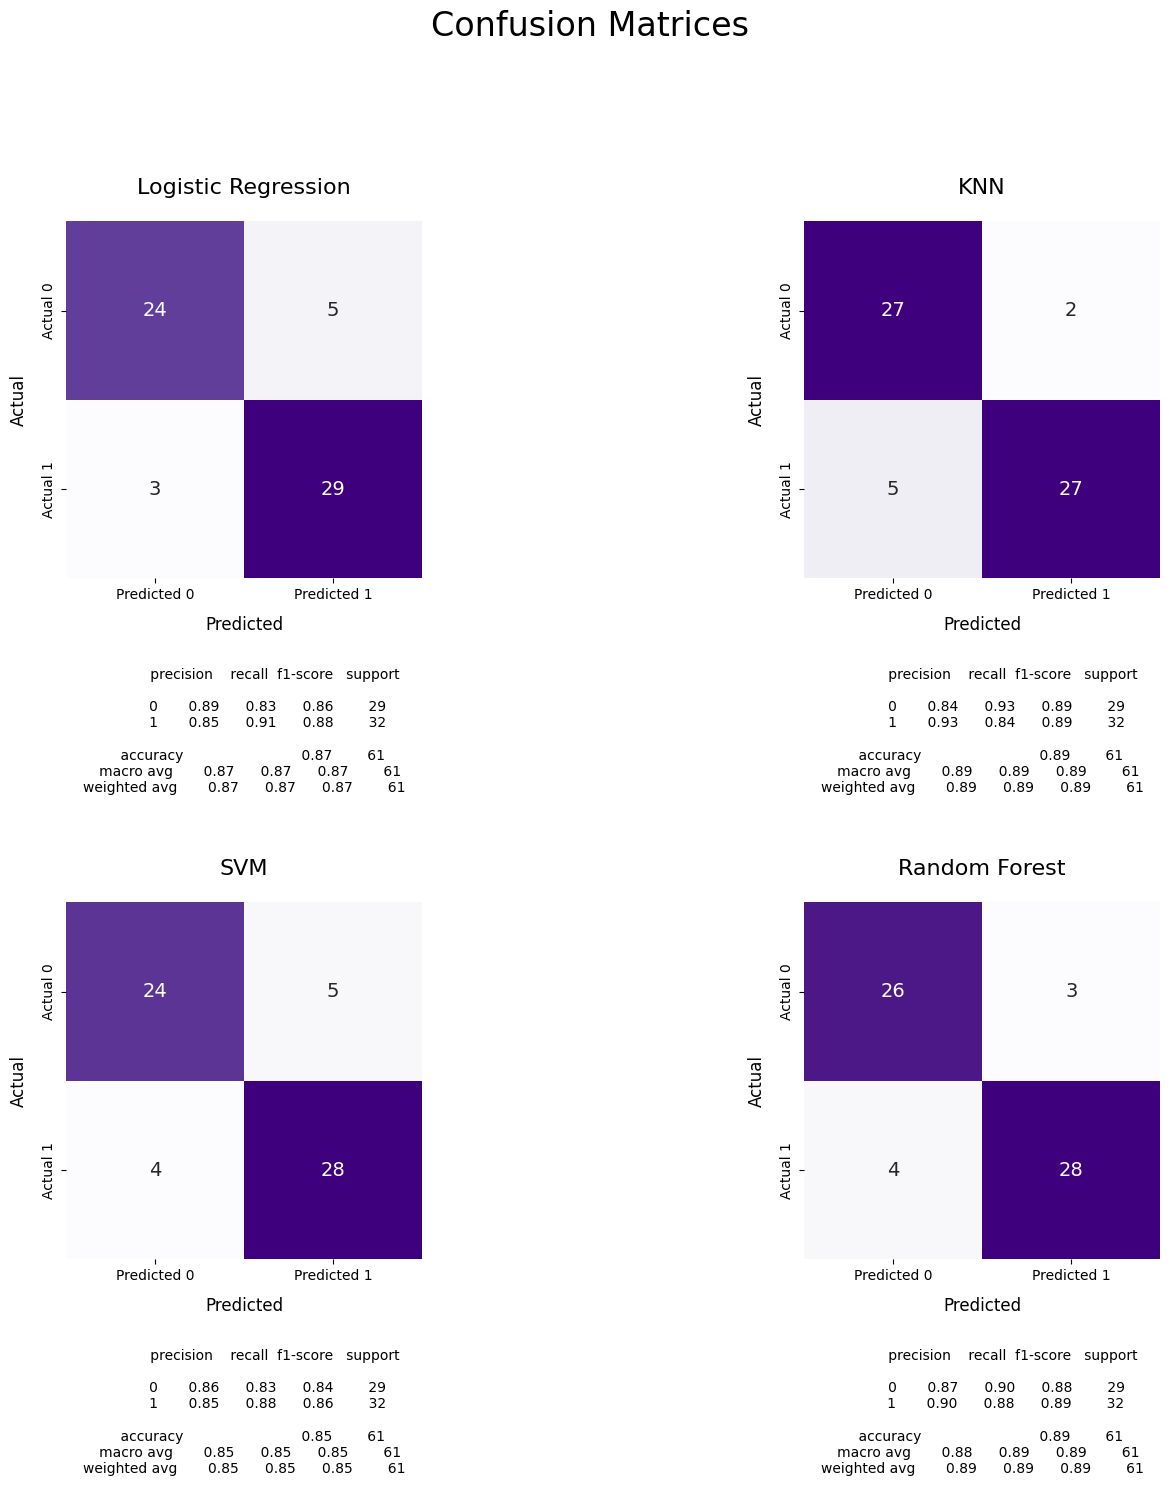

In [31]:
def Evaluate_model(model, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return model_name, cm, report

results = [
    Evaluate_model(best_log_reg_model, "Logistic Regression"),
    Evaluate_model(best_knn_model, "KNN"),
    Evaluate_model(best_svm_model, "SVM"),
    Evaluate_model(best_rf, "Random Forest")
]

plt.figure(figsize=(15, 15))
plt.suptitle("Confusion Matrices", fontsize=24, y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.4, bottom=0.1)

for i, (name, cm, report) in enumerate(results):
    plt.subplot(2, 2, i+1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"],
                cbar=False, square=True, annot_kws={'size': 14})
    plt.title(name, fontsize=16, pad=20)
    plt.xlabel("Predicted", fontsize=12, labelpad=10)
    plt.ylabel("Actual", fontsize=12, labelpad=10)

    plt.gca().text(0.5, -0.25, report,
                  fontsize=10,
                  ha='center',
                  va='top',
                  transform=plt.gca().transAxes,
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [32]:

joblib.dump(best_log_reg_model, 'logistic_model.pkl')
joblib.dump(best_svm_model, 'svm_model.pkl')
joblib.dump(best_knn_model, 'knn_model.pkl')
joblib.dump(best_dt_model, 'dt_model.pkl')

['dt_model.pkl']